In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

sns.set(context="notebook", style="whitegrid")
RNG = 42

# ----- link transform to keep predictions in [-1, 1] -----
_EPS = 1e-6
def y_to_z(y):
    y_ = np.clip(y, -1 + _EPS, 1 - _EPS)
    return np.arctanh(y_)
def z_to_y(z):
    return np.clip(np.tanh(z), -1.0, 1.0)

def report_metrics(y_true, y_pred, label=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    print(f"{label}RMSE={rmse:.4f} | MAE={mae:.4f} | R^2={r2:.4f} | EVS={evs:.4f}")
    return dict(rmse=rmse, mae=mae, r2=r2, evs=evs)

def concat_years(start_year: int, end_year: int, base_dir: str, type:str="10K"):
    """
    Concatenate yearly parquet files into a single DataFrame.
    
    Parameters
    ----------
    start_year : int
        First year (inclusive).
    end_year : int
        Last year (inclusive).
    base_dir : str
        Path to the directory containing parquet files.
    
    Returns
    -------
    pd.DataFrame
        Combined DataFrame of all years.
    """
    dfs = []
    for year in range(start_year, end_year + 1):
        if type == "10K":
            path = os.path.join(base_dir, f"{year}_mgmt_training_{type}.parquet")
            if os.path.exists(path):
                year_df = pd.read_parquet(path, engine="fastparquet")
                dfs.append(year_df)
            else:
                print(f"⚠️ Skipping missing file: {path}")

        elif type == '10Q':
            path = os.path.join(base_dir, f"{year}_mgmt_training_{type}.parquet")
            if os.path.exists(path):
                year_df = pd.read_parquet(path, engine="fastparquet")
                dfs.append(year_df)
            else:
                print(f"⚠️ Skipping missing file: {path}")
                
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [ ]:
df = concat_years(2005, 2013, "../../data/training_data_surprise_model")

# Ensure "date" is string and extract the year
df["year"] = df["date"].astype(str).str[:4].astype(int)

# Training: 2005–2011
train_df = df[df["year"].between(2005, 2011)]

# Testing: 2012–2023
val_df  = df[df["year"].between(2012, 2012)]

test_df  = df[df["year"].between(2013, 2013)]

print("Train shape:", train_df.shape)
print("Validation shape :", val_df.shape)

# Build feature/target arrays
X_train = np.vstack(train_df["mgmt_embedding"].values).astype(np.float32)
y_train = train_df["ni_be"].to_numpy(np.float32)

X_val  = np.vstack(val_df["mgmt_embedding"].values).astype(np.float32)
y_val  = val_df["ni_be"].to_numpy(np.float32)

X_test  = np.vstack(test_df["mgmt_embedding"].values).astype(np.float32)
y_test  = test_df["ni_be"].to_numpy(np.float32)

# Enforce bounds + latent transform
y_train = np.clip(y_train, -1, 1)
y_val  = np.clip(y_val, -1, 1)

z_train = y_to_z(y_train)
z_test  = y_to_z(y_val)

X_train.shape, X_val.shape


Train shape: (24077, 6)
Validation shape : (3174, 6)


((24077, 768), (3174, 768))

In [21]:
df

,cik,gvkey,date,mgmt_embedding,ni_be,year
0,6284,1633.0,2005-02,"[-0.34999558, 1.3695177, -0.57309455, -0.23077...",0.022688,2005
1,796343,12540.0,2005-02,"[-0.22411665, 1.2341002, -0.8456317, -0.210903...",0.326916,2005
2,1090061,124254.0,2005-02,"[-0.13306156, 0.7813514, -0.5372533, -1.045033...",-1.090630,2005
3,860748,21503.0,2005-02,"[-0.17241207, 1.1899269, -0.5319485, -0.637415...",0.107652,2005
4,878436,117905.0,2005-02,"[-0.017556176, 1.4124045, -1.1808175, -0.27374...",-0.866514,2005
...,...,...,...,...,...,...
30335,12040,4759.0,2013-12,"[-0.22400247, 1.3385937, -0.60099363, -0.21115...",0.101953,2013
30336,718924,9916.0,2013-12,"[-0.3689939, 0.35381275, -0.30409214, -0.62189...",0.179316,2013
30337,725363,12711.0,2013-12,"[0.49581188, 0.2883304, 0.19880572, -0.4518687...",-1.287088,2013
30338,825324,22543.0,2013-12,"[0.05479331, 0.3947918, -0.32850817, -0.390770...",-0.208997,2013


In [23]:
# Pipeline: (optional) Standardize -> PCA -> KernelRidge(RBF)
# Standardization helps PCA; embeddings are often already scaled, but this is safe.
base_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False for sparse safety; ok for dense too
    ("pca", PCA(random_state=RNG)),
    ("krr", KernelRidge(kernel="rbf"))
])

# Wrap so we train on atanh(y) but score/predict on bounded y
model = TransformedTargetRegressor(
    regressor=base_pipe,
    func=y_to_z,
    inverse_func=z_to_y
)


## Fold CV

In [ ]:
# Ensure bounds (just in case)
y_train = np.clip(y_train, -1, 1)
y_val  = np.clip(y_val,  -1, 1)

kfold = KFold(n_splits=5, shuffle=True, random_state=RNG)

# Search ranges (kept light for CPU; widen if you want)
param_dist = {
    "regressor__pca__n_components": [16, 32, 48, 96, 128],
    "regressor__krr__alpha":        np.geomspace(1e-3, 1e1, 10),
    "regressor__krr__gamma":        np.geomspace(1e-4, 1e0, 10),
}

num_cores = os.cpu_count()

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=60,                                # reduce to ~30 if needed
    scoring="neg_root_mean_squared_error",    # scored in y-space (thanks to TTR)
    cv=kfold,
    n_jobs=num_cores - 1,
    random_state=RNG,
    verbose=1,
    refit=True,
    return_train_score=True,
)

search.fit(X_train, y_train)
print("Best CV RMSE:", -search.best_score_)
best_ttr = search.best_estimator_
best_params = search.best_params_
best_params


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning:

Best CV RMSE: 0.32118226289749147


{'regressor__pca__n_components': 48,
 'regressor__krr__gamma': np.float64(0.08111308307896872),
 'regressor__krr__alpha': np.float64(0.8111308307896873)}

In [43]:
best_params = {
    'regressor__pca__n_components': 48,
    'regressor__krr__gamma': np.float64(0.08111308307896872),
    'regressor__krr__alpha': np.float64(0.8111308307896873)
}

# Define the pipeline with best hyperparameters
base_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("pca", PCA(n_components=best_params['regressor__pca__n_components'], random_state=RNG)),
    ("krr", KernelRidge(kernel="rbf", 
                        alpha=best_params['regressor__krr__alpha'],
                        gamma=best_params['regressor__krr__gamma']))
])

# Wrap with target transform
best_model = TransformedTargetRegressor(
    regressor=base_pipe,
    func=y_to_z,
    inverse_func=z_to_y
)

# Train model
best_model.fit(X_train, y_train)

# Evaluate on validation/test
train_score = best_model.score(X_train, y_train)
val_score   = best_model.score(X_val, y_val)

print("Train R^2:", train_score)
print("Val R^2:", val_score)

# Predict
y_val_pred = best_model.predict(X_val)
best_ttr = best_model

/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


Train R^2: 0.8426094055175781
Val R^2: -0.017658591270446777


In [44]:
y_tr_pred = best_ttr.predict(X_train)  # already bounded to [-1,1]
y_te_pred = best_ttr.predict(X_val)

print("== Regression metrics ==")
train_stats = report_metrics(y_train, y_tr_pred, "Train → ")
test_stats  = report_metrics(y_val,  y_te_pred, "Test  → ")


== Regression metrics ==
Train → RMSE=0.1303 | MAE=0.0749 | R^2=0.8426 | EVS=0.8491
Test  → RMSE=0.3066 | MAE=0.1883 | R^2=-0.0177 | EVS=-0.0009


In [ ]:
cvdf = pd.DataFrame(search.cv_results_)
cvdf["mean_rmse"] = -cvdf["mean_test_score"]

# Scatter: RMSE vs gamma (log), color by alpha, size by n_components
fig, ax = plt.subplots(figsize=(8,5))
sc = ax.scatter(
    cvdf["param_regressor__krr__gamma"].astype(float),
    cvdf["mean_rmse"],
    c=np.log10(cvdf["param_regressor__krr__alpha"].astype(float)),
    s=cvdf["param_regressor__pca__n_components"].astype(float),
    alpha=0.9
)
ax.set_xscale("log")
ax.set_xlabel("gamma (RBF)")
ax.set_ylabel("CV RMSE (lower=better)")
ax.set_title("RandomizedSearchCV — PCA + KernelRidge (RBF)")
cb = plt.colorbar(sc, ax=ax); cb.set_label("log10(alpha)")
plt.tight_layout(); plt.show()

# Quick heatmap at the best alpha to visualize gamma vs n_components
best_alpha = best_params["regressor__krr__alpha"]
hmdf = (cvdf[np.isclose(cvdf["param_regressor__krr__alpha"].astype(float), best_alpha)]
        .pivot_table(index="param_regressor__pca__n_components",
                     columns="param_regressor__krr__gamma",
                     values="mean_rmse", aggfunc="min"))
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(hmdf, cmap="viridis", ax=ax)
ax.set_title(f"CV RMSE heatmap @ alpha={best_alpha:.3g}")
ax.set_xlabel("gamma"); ax.set_ylabel("n_components")
plt.tight_layout(); plt.show()


In [47]:
best_nc   = best_params["regressor__pca__n_components"]
best_alpha= best_params["regressor__krr__alpha"]

gammas = np.geomspace(1e-4, 1e0, 20)
gen = []

for g in gammas:
    ttr = TransformedTargetRegressor(
        regressor=Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("pca", PCA(n_components=best_nc, random_state=RNG)),
            ("krr", KernelRidge(kernel="rbf", alpha=best_alpha, gamma=g)),
        ]),
        func=y_to_z, inverse_func=z_to_y
    )
    ttr.fit(X_train, y_train)
    y_tr = ttr.predict(X_train)
    y_te = ttr.predict(X_val)
    gen.append({
        "gamma": g,
        "train_rmse": root_mean_squared_error(y_train, y_tr),
        "test_rmse":  root_mean_squared_error(y_val,  y_te),
    })
    print(f"Trained model with gen {gen[-1]}")

gen_df = pd.DataFrame(gen)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(gammas, gen_df["train_rmse"], marker="o", label="Train RMSE")
ax.plot(gammas, gen_df["test_rmse"],  marker="o", label="Test RMSE")
ax.axvline(best_params["regressor__krr__gamma"], color="red", ls="--", label="Best gamma (CV)")
ax.set_xscale("log")
ax.set_xlabel("gamma (RBF)"); ax.set_ylabel("RMSE (y-space)")
ax.set_title("Generalization Curve — vary gamma")
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


Trained model with gen {'gamma': np.float64(0.0001), 'train_rmse': 0.41658252477645874, 'test_rmse': 0.4293699264526367}


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


Trained model with gen {'gamma': np.float64(0.0001623776739188721), 'train_rmse': 0.41354072093963623, 'test_rmse': 0.42941319942474365}


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


Trained model with gen {'gamma': np.float64(0.00026366508987303583), 'train_rmse': 0.40813884139060974, 'test_rmse': 0.42844241857528687}


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


KeyboardInterrupt: 

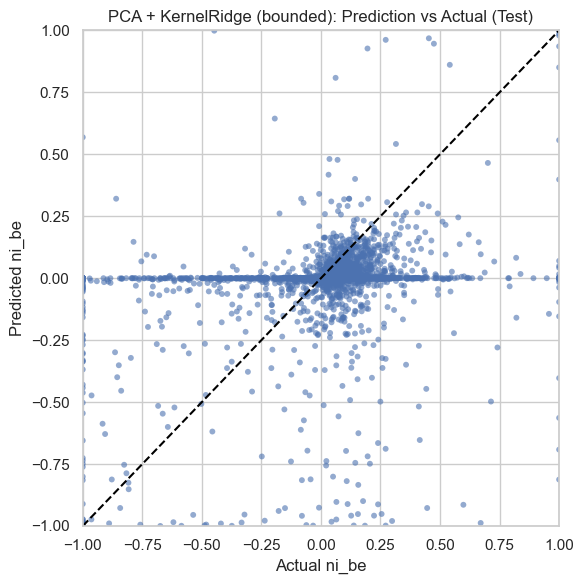

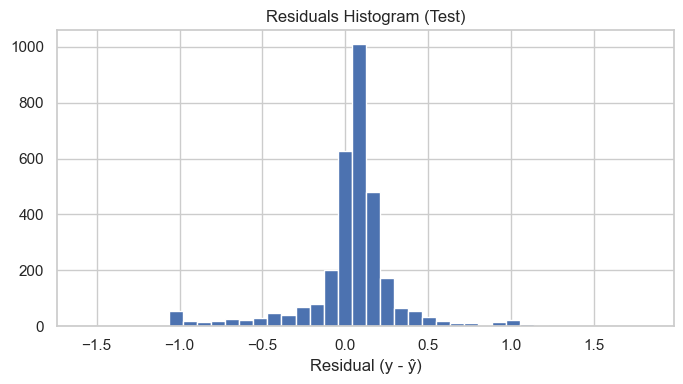

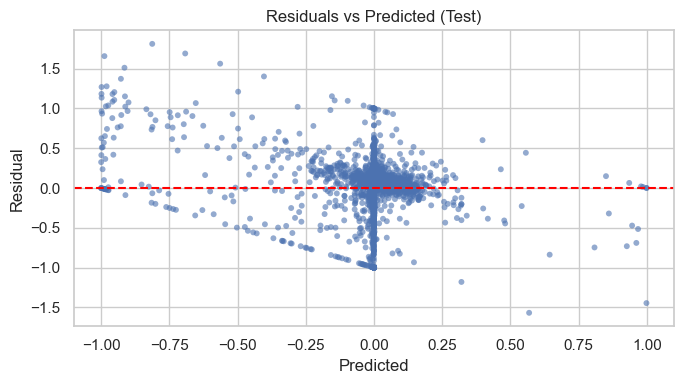

In [48]:
# Prediction vs Actual
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_val, y_te_pred, s=18, alpha=0.6, edgecolors="none")
lims = [-1, 1]
ax.plot(lims, lims, "--", color="black")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Actual ni_be"); ax.set_ylabel("Predicted ni_be")
ax.set_title("PCA + KernelRidge (bounded): Prediction vs Actual (Test)")
plt.tight_layout(); plt.show()

# Residuals
res = y_val - y_te_pred
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(res, bins=40)
ax.set_title("Residuals Histogram (Test)")
ax.set_xlabel("Residual (y - ŷ)")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_te_pred, res, s=18, alpha=0.6, edgecolors="none")
ax.axhline(0.0, ls="--", color="red")
ax.set_title("Residuals vs Predicted (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
plt.tight_layout(); plt.show()


/var/folders/66/lykx91p150q4wl3w7w5ypwdh0000gn/T/ipykernel_16687/2269991899.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin").agg(pred_mean=("pred","mean"), actual_mean=("actual","mean"), count=("actual","size")).dropna()


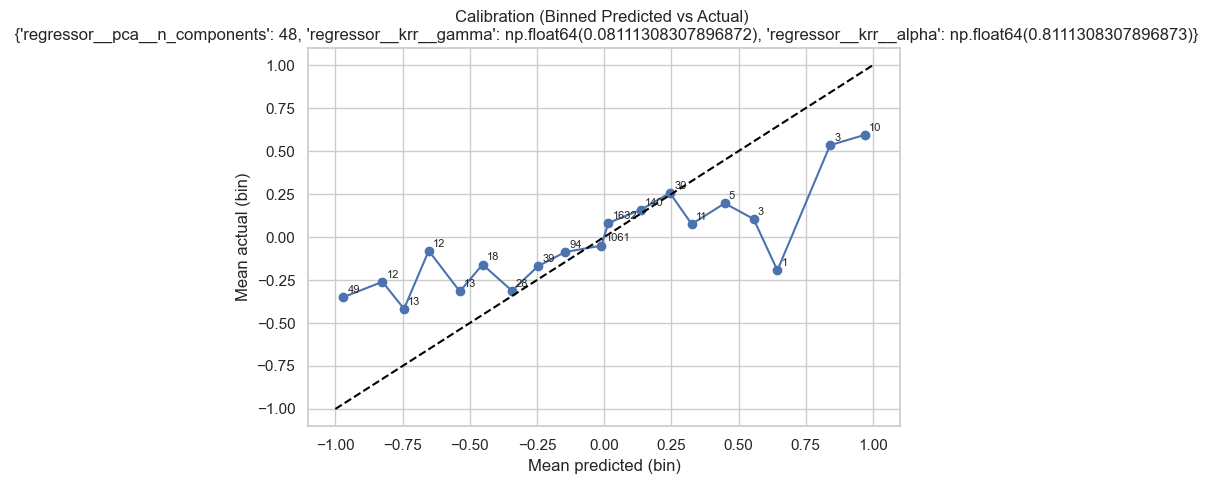

In [49]:

# compute bins on predictions
bins = np.linspace(-1, 1, 21)  # 20 bins across [-1,1]
cats = pd.cut(y_te_pred, bins=bins, include_lowest=True)
calib = pd.DataFrame({"pred": y_te_pred, "actual": y_val, "bin": cats}) \
            .groupby("bin").agg(pred_mean=("pred","mean"), actual_mean=("actual","mean"), count=("actual","size")).dropna()

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(calib["pred_mean"], calib["actual_mean"], marker="o")
ax.plot([-1,1], [-1,1], "--", color="black")
ax.set_title(f"Calibration (Binned Predicted vs Actual) \n {best_params}")
ax.set_xlabel("Mean predicted (bin)"); ax.set_ylabel("Mean actual (bin)")
for x, n in zip(calib["pred_mean"], calib["count"]):
    ax.annotate(str(int(n)), (x, calib.loc[calib["pred_mean"]==x, "actual_mean"].values[0]), fontsize=8, xytext=(3,3), textcoords="offset points")
plt.tight_layout(); plt.show()


/var/folders/66/lykx91p150q4wl3w7w5ypwdh0000gn/T/ipykernel_16687/1651341166.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  err = pd.DataFrame({"abs_err": np.abs(y_val - y_te_pred), "bin": q}).groupby("bin")["abs_err"].mean()


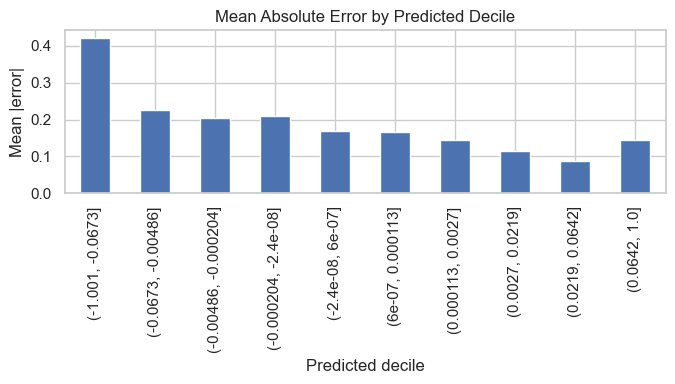

In [50]:
q = pd.qcut(y_te_pred, q=10, duplicates="drop")  # deciles by predicted
err = pd.DataFrame({"abs_err": np.abs(y_val - y_te_pred), "bin": q}).groupby("bin")["abs_err"].mean()

fig, ax = plt.subplots(figsize=(7,4))
err.plot(kind="bar", ax=ax)
ax.set_title("Mean Absolute Error by Predicted Decile")
ax.set_xlabel("Predicted decile"); ax.set_ylabel("Mean |error|")
plt.tight_layout(); plt.show()


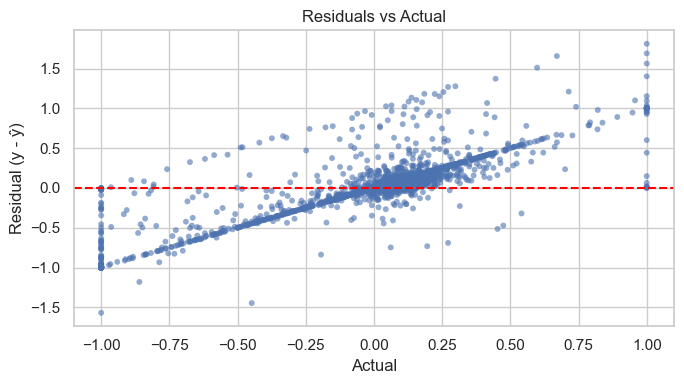

In [51]:
res = y_val - y_te_pred

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_val, res, s=18, alpha=0.6, edgecolors="none")
ax.axhline(0.0, ls="--", color="red")
ax.set_title("Residuals vs Actual")
ax.set_xlabel("Actual"); ax.set_ylabel("Residual (y - ŷ)")
plt.tight_layout(); plt.show()


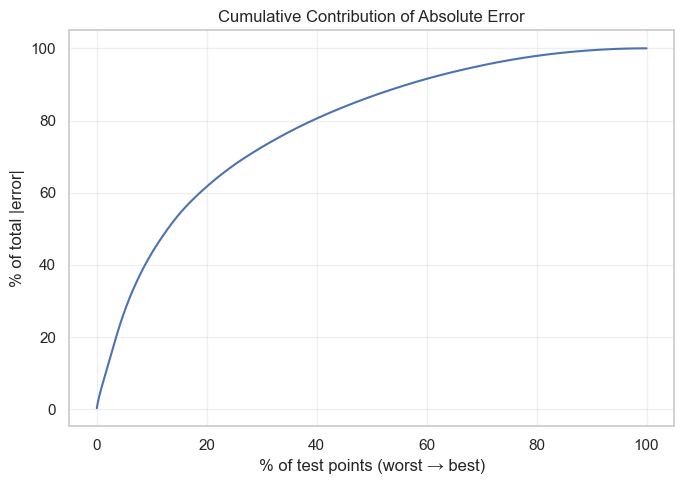

In [52]:
abs_err = np.abs(y_val - y_te_pred)
sorted_err = np.sort(abs_err)[::-1]  # largest first
cum_frac_err = np.cumsum(sorted_err) / sorted_err.sum()
frac_points = np.arange(1, len(abs_err)+1) / len(abs_err)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(frac_points*100, cum_frac_err*100)
ax.set_title("Cumulative Contribution of Absolute Error")
ax.set_xlabel("% of test points (worst → best)")
ax.set_ylabel("% of total |error|")
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


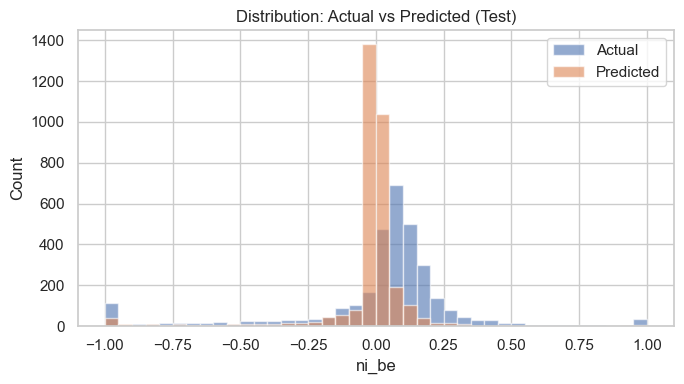

In [53]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(y_val, bins=40, alpha=0.6, label="Actual")
ax.hist(y_te_pred, bins=40, alpha=0.6, label="Predicted")
ax.set_title("Distribution: Actual vs Predicted (Test)")
ax.set_xlabel("ni_be"); ax.set_ylabel("Count")
ax.legend()
plt.tight_layout(); plt.show()


## Isotonic Calibration

In [ ]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import joblib
import numpy as np

def metrics(y, yhat):
    return dict(
        rmse=float(root_mean_squared_error(y, yhat)),
        mae=float(mean_absolute_error(y, yhat)),
        r2=float(r2_score(y, yhat)),
        evs=float(explained_variance_score(y, yhat))
    )

# 1) Raw predictions
y_val_raw  = best_ttr.predict(X_val)   # already in [-1,1]
y_test_raw = best_ttr.predict(X_test)

# 2) Fit isotonic mapping on validation set
iso = IsotonicRegression(y_min=-1, y_max=1, out_of_bounds="clip")
iso.fit(y_val_raw, y_val)

# 3) Calibrated predictions
y_val_cal  = iso.predict(y_val_raw)
y_test_cal = iso.predict(y_test_raw)

print("Val  raw :", metrics(y_val,  y_val_raw))
print("Val  calib:", metrics(y_val,  y_val_cal))
print("Test raw :", metrics(y_test, y_test_raw))
print("Test calib:", metrics(y_test, y_test_cal))

# 4) Save calibrator
joblib.dump(iso, "artifacts/isotonic_calibrator_2012.joblib")
print("Saved → artifacts/isotonic_calibrator_2012.joblib")


Val  raw : {'rmse': 0.30658864974975586, 'mae': 0.18834170699119568, 'r2': -0.017658591270446777, 'evs': -0.0008902549743652344}
Val  calib: {'rmse': 0.281377911567688, 'mae': 0.17084310948848724, 'r2': 0.14282411336898804, 'evs': 0.14288073778152466}
Test raw : {'rmse': 4.081755638122559, 'mae': 0.43247607350349426, 'r2': 0.0013955235481262207, 'evs': 0.0014938712120056152}
Test calib: {'rmse': 4.081602096557617, 'mae': 0.4151814877986908, 'r2': 0.001470804214477539, 'evs': 0.001837015151977539}
Saved → artifacts/isotonic_calibrator_2012.joblib


== Validation ==
Raw : {'rmse': 0.30658864974975586, 'mae': 0.18834170699119568, 'r2': -0.017658591270446777, 'evs': -0.0008902549743652344}
Cal : {'rmse': 0.281377911567688, 'mae': 0.17084310948848724, 'r2': 0.14282411336898804, 'evs': 0.14288073778152466}

== Test ==
Raw : {'rmse': 4.081755638122559, 'mae': 0.43247607350349426, 'r2': 0.0013955235481262207, 'evs': 0.0014938712120056152}
Cal : {'rmse': 4.081602096557617, 'mae': 0.4151814877986908, 'r2': 0.001470804214477539, 'evs': 0.001837015151977539}


/var/folders/66/lykx91p150q4wl3w7w5ypwdh0000gn/T/ipykernel_16687/864357306.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")
/var/folders/66/lykx91p150q4wl3w7w5ypwdh0000gn/T/ipykernel_16687/864357306.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


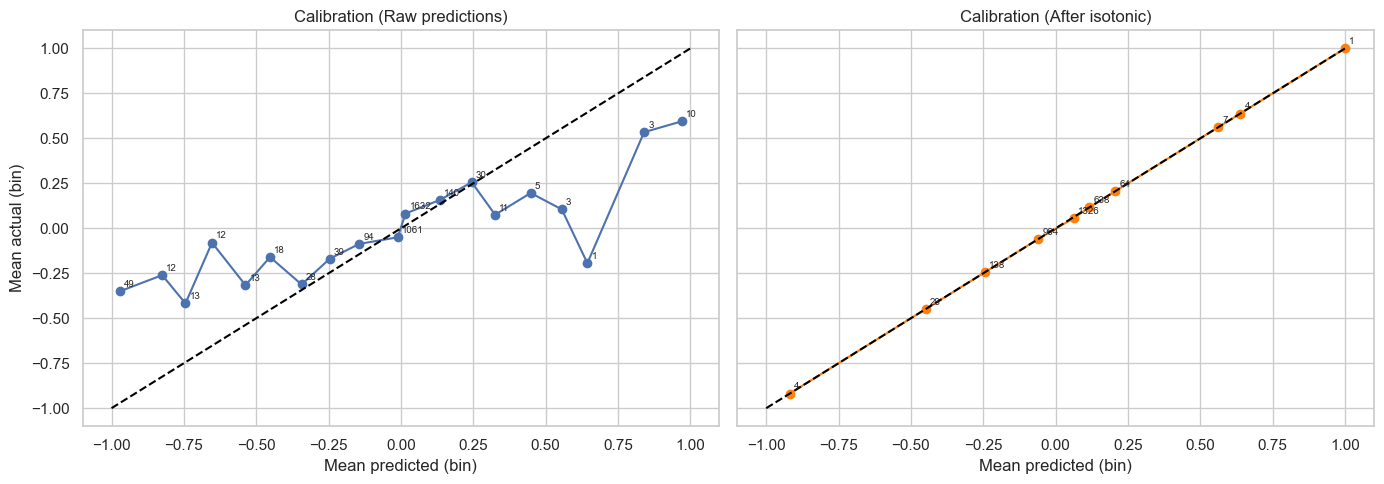

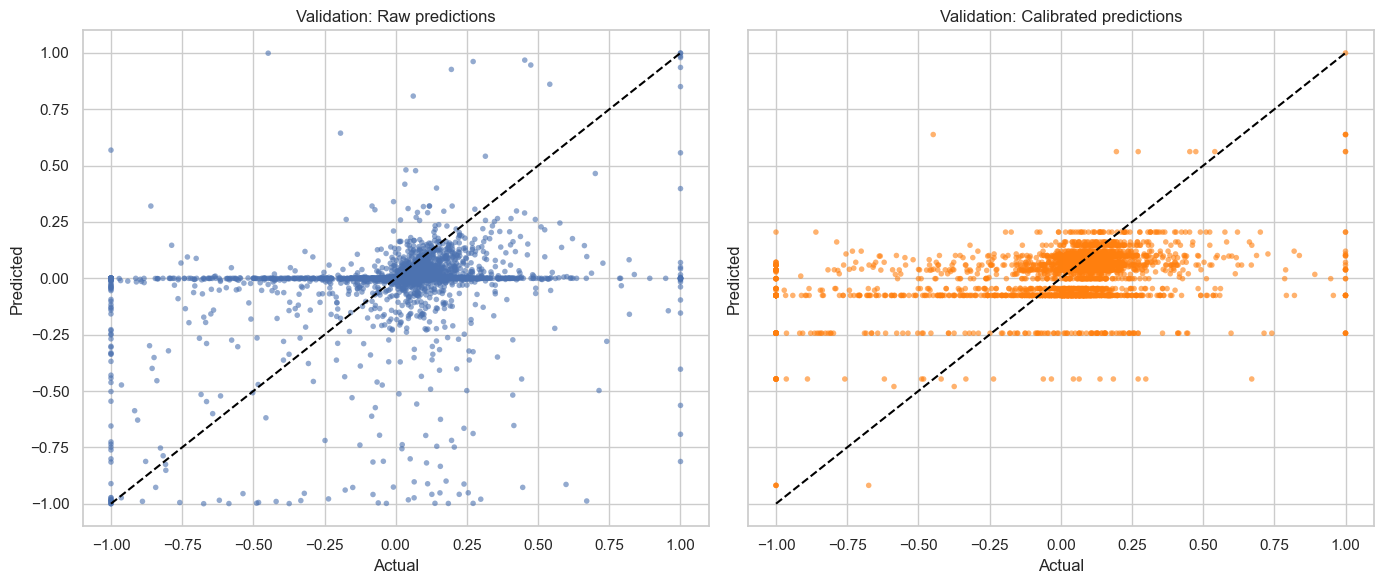

In [55]:
# --- Metrics comparison ---
print("== Validation ==")
print("Raw :", metrics(y_val, y_val_raw))
print("Cal :", metrics(y_val, y_val_cal))

print("\n== Test ==")
print("Raw :", metrics(y_test, y_test_raw))
print("Cal :", metrics(y_test, y_test_cal))


# --- Calibration curves side-by-side ---
bins = np.linspace(-1, 1, 21)

def calibration_df(y_pred, y_true, bins):
    cats = pd.cut(y_pred, bins=bins, include_lowest=True)
    return (
        pd.DataFrame({"pred": y_pred, "actual": y_true, "bin": cats})
        .groupby("bin")
        .agg(
            pred_mean=("pred", "mean"),
            actual_mean=("actual", "mean"),
            count=("actual", "size")
        )
        .dropna()
    )

calib_raw = calibration_df(y_val_raw, y_val, bins)
calib_cal = calibration_df(y_val_cal, y_val, bins)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Raw
ax[0].plot(calib_raw["pred_mean"], calib_raw["actual_mean"], marker="o")
ax[0].plot([-1,1], [-1,1], "--", color="black")
ax[0].set_title("Calibration (Raw predictions)")
ax[0].set_xlabel("Mean predicted (bin)")
ax[0].set_ylabel("Mean actual (bin)")
for x,y,n in zip(calib_raw["pred_mean"], calib_raw["actual_mean"], calib_raw["count"]):
    ax[0].annotate(str(int(n)), (x,y), fontsize=7, xytext=(3,3), textcoords="offset points")

# Right: Calibrated
ax[1].plot(calib_cal["pred_mean"], calib_cal["actual_mean"], marker="o", color="tab:orange")
ax[1].plot([-1,1], [-1,1], "--", color="black")
ax[1].set_title("Calibration (After isotonic)")
ax[1].set_xlabel("Mean predicted (bin)")
for x,y,n in zip(calib_cal["pred_mean"], calib_cal["actual_mean"], calib_cal["count"]):
    ax[1].annotate(str(int(n)), (x,y), fontsize=7, xytext=(3,3), textcoords="offset points")

plt.tight_layout()
plt.show()


# --- Prediction vs Actual scatter (raw vs calibrated) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

lims = [-1,1]

ax[0].scatter(y_val, y_val_raw, s=16, alpha=0.6, edgecolors="none")
ax[0].plot(lims, lims, "--", color="black")
ax[0].set_title("Validation: Raw predictions")
ax[0].set_xlabel("Actual"); ax[0].set_ylabel("Predicted")

ax[1].scatter(y_val, y_val_cal, s=16, alpha=0.6, edgecolors="none", color="tab:orange")
ax[1].plot(lims, lims, "--", color="black")
ax[1].set_title("Validation: Calibrated predictions")
ax[1].set_xlabel("Actual"); ax[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()


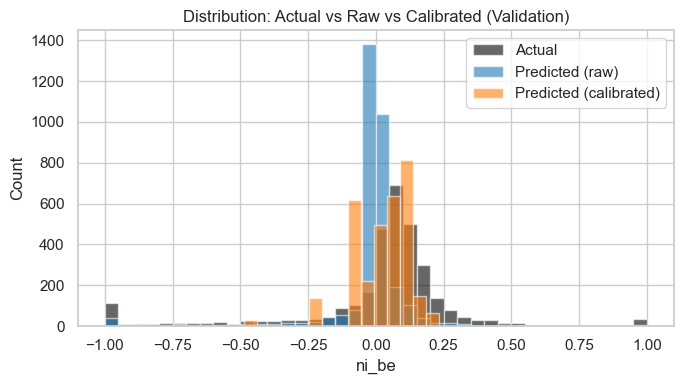

In [28]:
fig, ax = plt.subplots(figsize=(7,4))

# Overlay actual, raw pred, and calibrated pred
ax.hist(y_val, bins=40, alpha=0.6, label="Actual", color="black")
ax.hist(y_val_raw, bins=40, alpha=0.6, label="Predicted (raw)", color="tab:blue")
ax.hist(y_val_cal, bins=40, alpha=0.6, label="Predicted (calibrated)", color="tab:orange")

ax.set_title("Distribution: Actual vs Raw vs Calibrated (Validation)")
ax.set_xlabel("ni_be")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()
plt.show()


## Platt Scaling

## Monotonic Cubic Spline

== Validation (PCHIP) ==
{'rmse': 0.30662733217015986, 'mae': 0.18538913068738716, 'r2': -0.017915370482073367, 'evs': -0.014330843053264264}
== Test (PCHIP) ==
{'rmse': 4.085224150093564, 'mae': 0.4279476768427194, 'r2': -0.0003023686895839983, 'evs': -9.252056429898126e-05}

== Validation (raw vs PCHIP) ==
Raw : {'rmse': 0.30658864974975586, 'mae': 0.18834170699119568, 'r2': -0.017658591270446777, 'evs': -0.0008902549743652344}
PCHIP: {'rmse': 0.30662733217015986, 'mae': 0.18538913068738716, 'r2': -0.017915370482073367, 'evs': -0.014330843053264264}

== Test (raw vs PCHIP) ==
Raw : {'rmse': 4.081755638122559, 'mae': 0.43247607350349426, 'r2': 0.0013955235481262207, 'evs': 0.0014938712120056152}
PCHIP: {'rmse': 4.085224150093564, 'mae': 0.4279476768427194, 'r2': -0.0003023686895839983, 'evs': -9.252056429898126e-05}
Saved → artifacts/pchip_calibrator_2012.joblib


/var/folders/66/lykx91p150q4wl3w7w5ypwdh0000gn/T/ipykernel_16687/2433731128.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


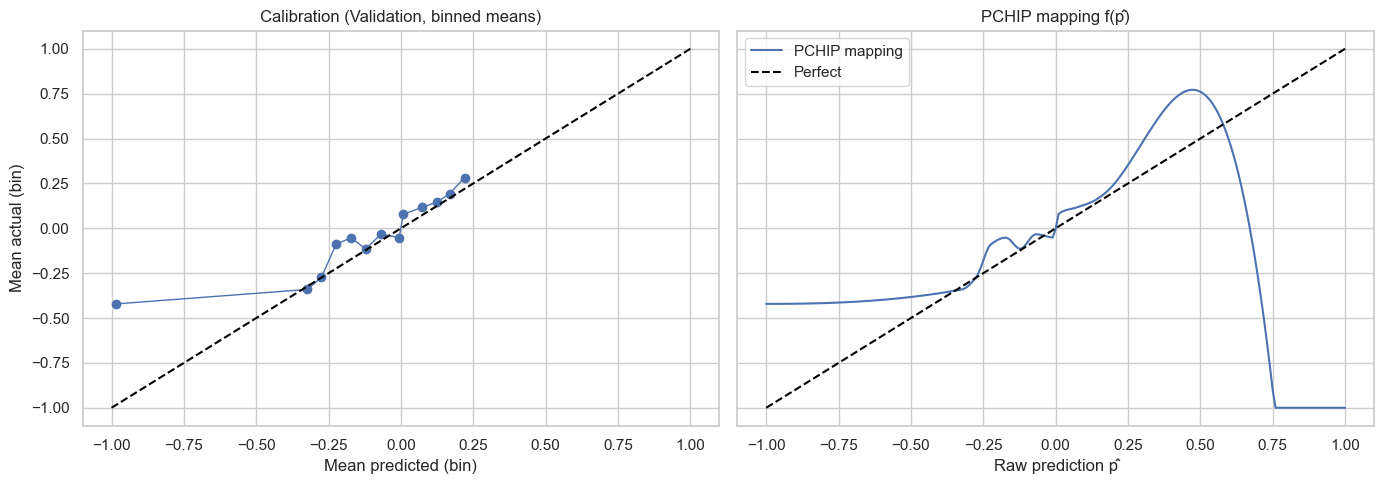

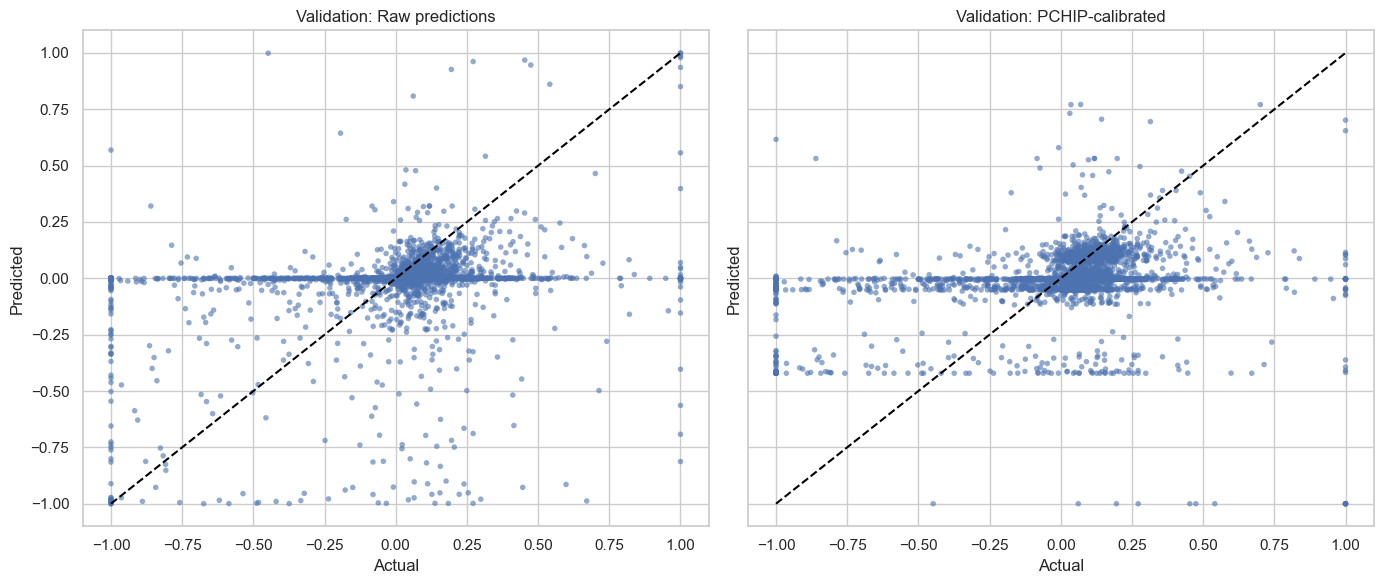

In [57]:
# --- PCHIP (monotonic cubic spline) calibration ---
from scipy.interpolate import PchipInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Raw predictions from your model
y_val_raw  = best_ttr.predict(X_val)
y_test_raw = best_ttr.predict(X_test)

# Helper: metrics (same as yours)
def metrics(y, yhat):
    from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
    return dict(
        rmse=float(root_mean_squared_error(y, yhat)),
        mae=float(mean_absolute_error(y, yhat)),
        r2=float(r2_score(y, yhat)),
        evs=float(explained_variance_score(y, yhat)),
    )

# ---- Fit the spline on a smoothed calibration curve from validation ----
# Build a calibration table on validation: bin by raw prediction, then average
bins = np.linspace(-1, 1, 41)  # 40 bins across [-1,1]
cats = pd.cut(y_val_raw, bins=bins, include_lowest=True)

calib_tbl = (
    pd.DataFrame({"pred": y_val_raw, "actual": y_val, "bin": cats})
    .groupby("bin")
    .agg(pred_mean=("pred", "mean"), actual_mean=("actual", "mean"), count=("actual", "size"))
    .dropna()
    .reset_index(drop=True)
)

# Keep only bins with enough samples to reduce noise
min_count = max(10, int(0.005 * len(y_val)))  # at least 0.5% of val set or 10
calib_tbl = calib_tbl[calib_tbl["count"] >= min_count].copy()

# Ensure strictly increasing x for PCHIP; drop duplicates if needed
calib_tbl = calib_tbl.sort_values("pred_mean")
calib_tbl = calib_tbl.drop_duplicates(subset=["pred_mean"], keep="first")

x = calib_tbl["pred_mean"].to_numpy()
y = calib_tbl["actual_mean"].to_numpy()

# Edge safety: if we don't have enough unique support, fall back to identity
if len(x) < 3:
    print("PCHIP: insufficient unique support; using identity mapping.")
    def pchip_predict(z):
        return np.clip(z, -1, 1)
else:
    # Fit shape-preserving monotone spline
    pchip = PchipInterpolator(x, y, extrapolate=True)

    def pchip_predict(z):
        # Evaluate spline and clip to bounds
        out = pchip(z)
        return np.clip(out, -1, 1)

# Calibrated predictions
y_val_pchip  = pchip_predict(y_val_raw)
y_test_pchip = pchip_predict(y_test_raw)

print("== Validation (PCHIP) ==")
print(metrics(y_val, y_val_pchip))
print("== Test (PCHIP) ==")
print(metrics(y_test, y_test_pchip))

# Compare against raw
print("\n== Validation (raw vs PCHIP) ==")
print("Raw :", metrics(y_val,  y_val_raw))
print("PCHIP:", metrics(y_val,  y_val_pchip))

print("\n== Test (raw vs PCHIP) ==")
print("Raw :", metrics(y_test, y_test_raw))
print("PCHIP:", metrics(y_test, y_test_pchip))

# Save the calibrator (as x,y knots for portability)
joblib.dump({"x": x, "y": y}, "artifacts/pchip_calibrator_2012.joblib")
print("Saved → artifacts/pchip_calibrator_2012.joblib")

# --- Plots: calibration curve and scatter ---
# 1) Calibration curve (using the binned table)
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Raw (bin means)
ax[0].plot(calib_tbl["pred_mean"], calib_tbl["actual_mean"], marker="o", linewidth=1)
ax[0].plot([-1,1], [-1,1], "--", color="black")
ax[0].set_title("Calibration (Validation, binned means)")
ax[0].set_xlabel("Mean predicted (bin)")
ax[0].set_ylabel("Mean actual (bin)")

# Right: Spline mapping line
grid = np.linspace(-1, 1, 201)
mapped = pchip_predict(grid)
ax[1].plot(grid, mapped, label="PCHIP mapping")
ax[1].plot([-1,1], [-1,1], "--", color="black", label="Perfect")
ax[1].set_title("PCHIP mapping f(p̂)")
ax[1].set_xlabel("Raw prediction p̂")
ax[1].legend()

plt.tight_layout()
plt.show()

# 2) Prediction vs Actual (raw vs PCHIP)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
lims = [-1, 1]

ax[0].scatter(y_val, y_val_raw, s=16, alpha=0.6, edgecolors="none")
ax[0].plot(lims, lims, "--", color="black")
ax[0].set_title("Validation: Raw predictions")
ax[0].set_xlabel("Actual"); ax[0].set_ylabel("Predicted")

ax[1].scatter(y_val, y_val_pchip, s=16, alpha=0.6, edgecolors="none")
ax[1].plot(lims, lims, "--", color="black")
ax[1].set_title("Validation: PCHIP-calibrated")
ax[1].set_xlabel("Actual"); ax[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()


## Histogram binning 

== Validation (Binning) ==
{'rmse': 0.2843321557487051, 'mae': 0.17436587588908073, 'r2': 0.12473029069815689, 'evs': 0.12473376031654626}
== Test (Binning) ==
{'rmse': 4.08155520996079, 'mae': 0.4175062514201758, 'r2': 0.001493567755878833, 'evs': 0.0018343959233582119}

== Validation (raw vs Binning) ==
Raw    : {'rmse': 0.30658864974975586, 'mae': 0.18834170699119568, 'r2': -0.017658591270446777, 'evs': -0.0008902549743652344}
Binning: {'rmse': 0.2843321557487051, 'mae': 0.17436587588908073, 'r2': 0.12473029069815689, 'evs': 0.12473376031654626}

== Test (raw vs Binning) ==
Raw    : {'rmse': 4.081755638122559, 'mae': 0.43247607350349426, 'r2': 0.0013955235481262207, 'evs': 0.0014938712120056152}
Binning: {'rmse': 4.08155520996079, 'mae': 0.4175062514201758, 'r2': 0.001493567755878833, 'evs': 0.0018343959233582119}
Saved → artifacts/binning_calibrator_2012.joblib


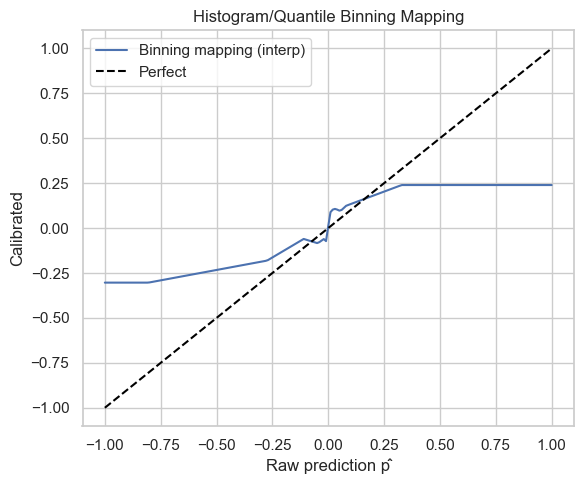

In [56]:
# --- Histogram (quantile) binning calibration ---
import numpy as np
import pandas as pd
import joblib

# Choose number of bins (quantile-based tends to be balanced)
n_bins = 30
quantiles = np.linspace(0, 1, n_bins + 1)
bin_edges = np.quantile(y_val_raw, quantiles)

# To avoid duplicate edges with constant regions
bin_edges = np.unique(bin_edges)
if len(bin_edges) < 3:
    print("Binning: insufficient unique edges; using identity mapping.")
    def binning_predict(z):
        return np.clip(z, -1, 1)
else:
    # Assign each val pred to a bin
    idx = np.searchsorted(bin_edges, y_val_raw, side="right") - 1
    idx = np.clip(idx, 0, len(bin_edges) - 2)

    # Compute per-bin average actual and bin centers
    df_bin = pd.DataFrame({"bin": idx, "actual": y_val, "pred": y_val_raw})
    bin_stats = (
        df_bin.groupby("bin")
        .agg(
            pred_mean=("pred", "mean"),
            actual_mean=("actual", "mean"),
            count=("actual", "size"),
        )
        .reset_index(drop=False)
        .sort_values("pred_mean")
    )

    # Build a piecewise-linear function through (pred_mean, actual_mean)
    xs = bin_stats["pred_mean"].to_numpy()
    ys = bin_stats["actual_mean"].to_numpy()

    # Deduplicate if any identical xs
    xs_unique, idx_unique = np.unique(xs, return_index=True)
    ys_unique = ys[idx_unique]

    # If still too few, identity fallback
    if len(xs_unique) < 2:
        print("Binning: degenerate centers; using identity mapping.")
        def binning_predict(z):
            return np.clip(z, -1, 1)
    else:
        def binning_predict(z):
            # Linear interpolation between bin centers, clipped at ends
            out = np.interp(z, xs_unique, ys_unique, left=ys_unique[0], right=ys_unique[-1])
            return np.clip(out, -1, 1)

# Apply
y_val_bin  = binning_predict(y_val_raw)
y_test_bin = binning_predict(y_test_raw)

print("== Validation (Binning) ==")
print(metrics(y_val, y_val_bin))
print("== Test (Binning) ==")
print(metrics(y_test, y_test_bin))

# Compare against raw
print("\n== Validation (raw vs Binning) ==")
print("Raw    :", metrics(y_val,  y_val_raw))
print("Binning:", metrics(y_val,  y_val_bin))

print("\n== Test (raw vs Binning) ==")
print("Raw    :", metrics(y_test, y_test_raw))
print("Binning:", metrics(y_test, y_test_bin))

# Save the binning calibrator artifacts to reuse (edges + center map)
joblib.dump(
    {"bin_edges": bin_edges, "xs": xs_unique, "ys": ys_unique},
    "artifacts/binning_calibrator_2012.joblib"
)
print("Saved → artifacts/binning_calibrator_2012.joblib")

# Plot mapping curve
import matplotlib.pyplot as plt
grid = np.linspace(-1, 1, 201)
mapped = binning_predict(grid)

plt.figure(figsize=(6,5))
plt.plot(grid, mapped, label="Binning mapping (interp)")
plt.plot([-1,1], [-1,1], "--", color="black", label="Perfect")
plt.title("Histogram/Quantile Binning Mapping")
plt.xlabel("Raw prediction p̂"); plt.ylabel("Calibrated")
plt.legend(); plt.tight_layout(); plt.show()
